In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# grab csv data
electric_gen = pd.read_csv('../electricity_generation_extractor/us_electric_generation_2001_20.csv')
us_emissions = pd.read_csv('us_emissions_2000_2018.csv')

In [3]:
# set emissions columns by sector
emissions_columns = ['State', 'Year', 'emission_sub_electric', 'emission_by_industrial', 'emission_by_agriculture', 'emission_by_waste',
                     'emission_by_forestry', 'emission_by_bunker_fuel', 'emission_sub_commercial', 'emission_sub_residential',
                     'emission_sub_industrial', 'emission_sub_transportation', 'emission_sub_fugitive']

ny_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='New York'), emissions_columns]
il_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='Illinois'), emissions_columns]
tx_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='Texas'), emissions_columns]

In [8]:
# define function to perform the grouping calculations on a dataframe
# returns the cleaned grouped df
def group_df_by_emissions(emissions_data):
    dirty_power = ['emission_sub_electric']
    buildings = ['emission_sub_residential', 'emission_sub_commercial']
    transportation = ['emission_sub_transportation']
    dumps_farms_industrial = ['emission_by_waste', 'emission_sub_industrial', 'emission_by_agriculture']
    fuels = ['emission_sub_fugitive', 'emission_by_bunker_fuel']

    columns_list = [['dirty_power', dirty_power], 
                    ['buildings', buildings],
                    ['transportation', transportation], 
                    ['dumps_farms_industrial', dumps_farms_industrial], 
                    ['fuels', fuels]]

    # build each bucketed totals
    for calc in columns_list: 
        emissions_data[calc[0]] = emissions_data.loc[:, calc[1]].sum(axis=1)
    
    # just rewrite a buckets list to concat through, sheer laziness here
    buckets = ['dirty_power', 'buildings', 'transportation', 'dumps_farms_industrial'] # emitted fuels from the totals for now
    # build the bucket % makeup for that year
    for bucket in buckets:
        emissions_data['%_'+bucket] = round(emissions_data[bucket] / emissions_data[buckets].sum(axis=1), 2) * 100

    return emissions_data

ny_emissions_chart_data = group_df_by_emissions(ny_emissions)
il_emissions_chart_data = group_df_by_emissions(il_emissions)
tx_emissions_chart_data = group_df_by_emissions(tx_emissions)


In [146]:
def show_area_plot_over_years_emissions(emissions_data, cols_to_keep):
    
    emissions_data.index = emissions_data['Year']
    bottom = np.zeros(len(emissions_data))

    fig , ax = plt.subplots()

    for i, col in enumerate(emissions_data[cols_to_keep]):
        ax.bar(
            emissions_data.index, 
            emissions_data[col],
            bottom=bottom)
        bottom += np.array(emissions_data[col])

    
    y_offset = -20
    list_iterator = 0
    total_list = [bar.get_height() for bar in ax.patches]
    
    for bar in ax.patches:
            
        
        ax.text(
            # Put the text in the middle of each bar. get_x returns the start
            # so we add half the width to get to the middle.
            bar.get_x() + bar.get_width() / 2,
            # Vertically, add the height of the bar to the start of the bar,
            # along with the offset.
            bar.get_height() + bar.get_y() + y_offset,
            # This is actual value we'll show.
            str(round(
                int(bar.get_height() / sum(total_list[list_iterator:len(total_list):18]) * 100))) + "%",
            # Center the labels and style them a bit.
            ha='center',
            color='w',
            weight='bold',
            size=10
        )
        
        # reset list iterator to next value or 0 again. Convuluated way to access the values
        # in ax.patches in the right order
        list_iterator = list_iterator + 1
        
        if list_iterator == 4:
            list_iterator = 0
        else: 
            pass

    plt.xlabel('Year')
    plt.xticks(emissions_data.index, rotation=0)

    plt.ylabel('Emissions (mtC02e)')
    

    legend_label = ['dirty power', 'buildings', 'transportation', 'dumps, farms, industrial']
    plt.legend(legend_label, ncol = 4, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)
    plt.title('{} emissions from 2001 - 2018\n'.format(emissions_data['State'].unique()[0]),loc='left')

    fig.set_size_inches(11.5, 8.5)
    plt.savefig('{}_emissions_2001-18.png'.format(emissions_data['State'].unique()[0]))
    plt.show()

In [148]:
# uncomment to show emissions plots
# this is assuming you've filtered down to one state per chart
cols_breakdown_100 = ['%_dirty_power', '%_buildings', '%_transportation', '%_dumps_farms_industrial']
cols_total = ['dirty_power', 'buildings', 'transportation', 'dumps_farms_industrial']
#show_area_plot_over_years_emissions(tx_emissions_chart_data, cols_total)


In [149]:
### let's do a similar thing with generation data
# subset our 3 states for now
target_cols = ['state', 'year', 'coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']

ny_electric_gen = electric_gen.loc[electric_gen['state']=='NY', target_cols]
il_electric_gen = electric_gen.loc[electric_gen['state']=='IL', target_cols]
tx_electric_gen = electric_gen.loc[electric_gen['state']=='TX', target_cols]

In [150]:
# define function to perform the grouping calculations on a dataframe
# returns the cleaned grouped df
def group_df_by_generation(generation_data):
    columns_list = ['coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']

    # build each bucketed totals
    for calc in columns_list: 
        generation_data[calc+'_%'] = round(generation_data[calc] / generation_data[columns_list].sum(axis=1), 2) * 100

    return generation_data

ny_generation_chart_data = group_df_by_generation(ny_electric_gen)
il_generation_chart_data = group_df_by_generation(il_electric_gen)
tx_generation_chart_data = group_df_by_generation(tx_electric_gen)


In [167]:
def show_area_plot_over_years_generation(generation_data, cols_to_keep):
    
    generation_data.index = generation_data['year']
    bottom = np.zeros(len(generation_data))

    fig , ax = plt.subplots()

    for i, col in enumerate(generation_data[cols_to_keep]):
        ax.bar(
            generation_data.index, 
            generation_data[col],
            bottom=bottom)
        bottom += np.array(generation_data[col])

    
    y_offset = -10000
    list_iterator = 0
    total_list = [bar.get_height() for bar in ax.patches]
    for bar in ax.patches:
        ax.text(
            # Put the text in the middle of each bar. get_x returns the start
            # so we add half the width to get to the middle.
            bar.get_x() + bar.get_width() / 2,
            # Vertically, add the height of the bar to the start of the bar,
            # along with the offset.
            bar.get_height() + bar.get_y() + y_offset,
            # This is actual value we'll show.
            str(round(
                int(bar.get_height() / sum(total_list[list_iterator:len(total_list):19]) * 100))) + "%" \
                if int(bar.get_height() / sum(total_list[list_iterator:len(total_list):19]) * 100) >= 10 else "" ,
            # Center the labels and style them a bit.
            ha='center',
            color='w',
            weight='bold',
            size=10
        )
        
    # reset list iterator to next value or 0 again. Convuluated way to access the values
        # in ax.patches in the right order
        list_iterator = list_iterator + 1
        
        if list_iterator == len(cols_to_keep):
            list_iterator = 0
        else: 
            pass

    plt.xlabel('Year')
    plt.xticks(generation_data.index, rotation=0)

    plt.ylabel('Electricity Generation (tMW hours)')
    

    legend_label = ['coal', 'natural gas', 'petro liquids', 'nuclear', 'hydro electric', 'solar', 'wind']
    plt.legend(legend_label, ncol = 7, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)
    plt.title('{} Elec generation from 2001 - 2020\n'.format(generation_data['state'].unique()[0]),loc='left')

    fig.set_size_inches(11.5, 8.5)
    plt.savefig('{}_elec_gen_2001-20.png'.format(generation_data['state'].unique()[0]))
    plt.show()

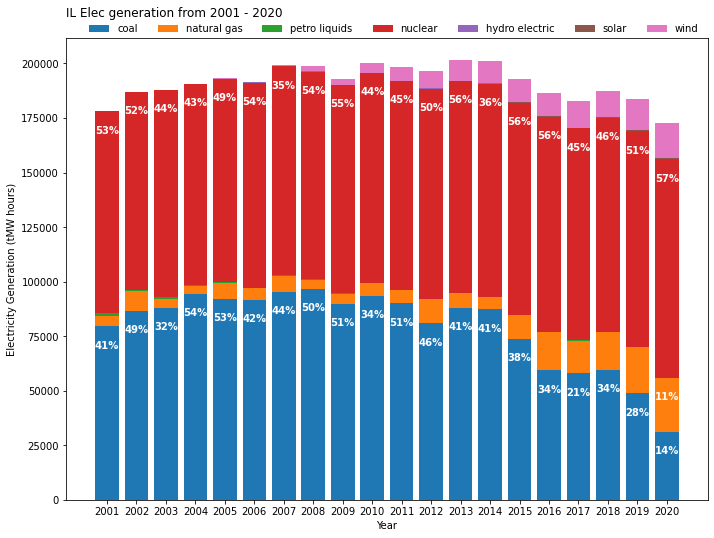

In [170]:
# cols_to_keep = ['coal_%', 'natural_gas_%', 'petro_liquids_%', 'nuclear_%', 'hydro_electric_%', 'all_solar_%', 'wind_%']
cols_totals = ['coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']
show_area_plot_over_years_generation(il_generation_chart_data, cols_totals)